## Niccolò Diana e Rebecca Solcia

# Simulation and Modelling individual Assignment - COVID19 (Ex. 1)

In [1]:
import os
import sys 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.stats import poisson  
from scipy.integrate import odeint

sns.set_palette("colorblind")

In [2]:
df_provinces = pd.read_csv('data_provinces.csv')

In [3]:
df_provinces.head()

,Unnamed: 0,LO,PV,SO,MN,MI,CO,BS,MB,LC,CR,BG,VA
0,0,0,0,0,1,0,1,2,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df_provinces.shape

(92, 13)

In [5]:
df_provinces.drop(columns=['Unnamed: 0'],inplace=True) # Pop the Unnamed column, because it is an indexer

We can see graphically the trend during the time spanned by the dataset on how the number of daily infected has changed conditionally on the county, for this we will use the 'df_provinces' data.

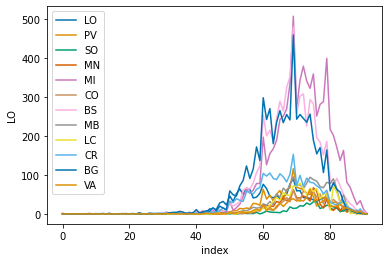

In [6]:
f, ax = plt.subplots(1, 1)
for col in df_provinces.columns:
    sns.lineplot(data=df_provinces.reset_index(),x='index', y=col,ax=ax)
plt.legend(df_provinces.columns)

It graphically makes sense that some provinces (due to the higher number of inhabitants) have higher numbers in absolute terms.
For a ceteris paribus analysis we would need to normalize by the total number of people that inhabit each province. Let us do so in the following snippets:

In [7]:
#The following data has been retrieved from the Assignment paper information,
initial_pops = {
    'LO':44928,
    'PV':71882,
    'SO':21477,
    'MN':48835,
    'MI':1406242,
    'CO':85543,
    'BS':196340,
    'MB':124840,
    'LC':48058,
    'CR':72399,
    'BG':120783,
    'VA':80724
}

**Next step:** We will now look at that same graph following on the idea of normalizing for the TOT number of inhabitants per province. This number will be the % of the people infected conditional on the province.

In [8]:
df_provinces_normalized = df_provinces.copy()
for col in df_provinces_normalized.columns:
    df_provinces_normalized[col]=df_provinces_normalized[col].apply(lambda x: np.divide(x,initial_pops[col]))

Let's plot the same output as we did before

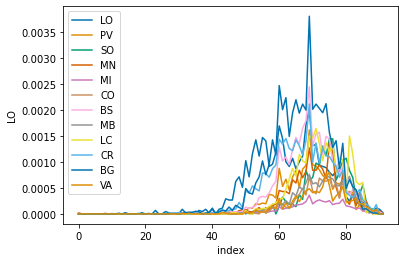

In [9]:
f, ax = plt.subplots(1, 1)
for col in df_provinces_normalized.columns:
    sns.lineplot(data=df_provinces_normalized.reset_index(),x='index', y=col,ax=ax)
plt.legend(df_provinces_normalized.columns)

# Exercise 1

A good way to model the epidemics we are facing is the SEIR model.

As explained in the paper by Battineni et al. (2020) - *SARS-CoV-2 epidemic calculation in Italy by SEIR compartmental models* - the SEIR model assumes relationships among people who are incubating the virus, present infected and the recovered or dead people at a given time for a certain population. As usual, S represents the susceptible population who is potentially subjected to infection. 

\begin{eqnarray}
    \frac{\partial S}{\partial t}= -\beta I \frac{S}{N}\\
    \frac{\partial E}{\partial t} = \beta I \frac{S}{N} - \delta E\\
    \frac{\partial I}{\partial t} = \delta E - \gamma I\\
    \frac{\partial R}{\partial t}= \gamma I\\
\end{eqnarray}

The infectious individuals **I** can spread the disease, each person exposes **beta** new cases per day, and **gamma** represents the recovery rate. The new transition probability E to I is one as very exposed individual turn into infected, the population E and the rate have new parameter **delta**.


*   *N*: Total population, with *N = S(t)+E(t)+I(t)+R(t)*
*   *Beta*: expected amount of people an infected person infects per day, expected to be D/S (i.e. average days needed to recover/susceptible individuals)
*   *Delta*: The rate at which exposed individuals turns into infectious cases. It is the inverse of the average latent time and governs the lag between having undergone an infectious contact and showing symptoms: in the equations, it brings people from the E category to the I category. The incubation period for COVID-19, which is the time between exposure to the virus (becoming infected) and symptom onset, is on average 5-6 days, however can be up to 14 days.
*   *Gamma*: The proportion of infected recovering per day (1/D) where D is the number of days an infected person can spread the disease. Since there are different opinions, this parameter will be tuned with a grid search.
*   *R0*: The total number of people an infected person infects (beta/gamma)


In [10]:
def SEIR_eq(INPUT, t,  beta, delta, gamma):
    S, E, I, R = INPUT
    N = S + E + I + R
    dS_dt = -(beta*S*I/N)
    dE_dt = (beta*S*I/N) - delta*E
    dI_dt =  delta*E - (gamma*I)
    dR_dt =  (gamma)*I
    return dS_dt, dE_dt, dI_dt, dR_dt

Once we have described the SEIR, we can initialize the parameters and create a number of dictionaries that will be needed to calibrate our model.

In [11]:
# Number of days for each province to train the model:
n_days = {'LO': 64, 'PV': 68, 'SO':74, 'MN': 74, 'MI': 68, 'CO': 68, 'BS': 68, 'MB': 68, 'LC': 70, 
          'CR': 66, 'BG': 66, 'VA': 73}
t_days_linspaced = {key:np.arange(1, val+1, 1) for idx,(key,val) in enumerate(n_days.items())}

# Initial populations (N):
initial_pops = {'LO':44928,'PV':71882,'SO':21477,'MN':48835,'MI':1406242,'CO':85543,'BS':196340,'MB':124840,'LC':48058,
                'CR':72399,'BG':120783,'VA':80724}

# Average infectious period:
d = 14

# Gamma, defined to be the inverse of the average infectious period:
gamma = 1/d

# Average latency period:
l = 6 

# Delta, defined to be the inverse of the average infectious period:
delta = 1/l

# Range of R0s to tune our model:
R0s = np.arange(0.6, 7, 0.001) #We test Ro from 1 to 2 by 0.001 increase.

Gamma beta and delta changing

## (1.1) Calibration with RMSE

In this first run of calibration, we do something different from what can be found in all the other calibrations you can find in this notebook. In fact, since we found a number of different evidences regarding the true value of the average infectious period, we decided to first perform a grid search through different values of *d* to find out which one best suited our case. We perform this grid search just a single time to avoid incurring in an unnecessary increase in complexity of our code. Likewise, while perorming a grid search on *d*, we also try to find its best match as far as the period *l* of incubation is concerned.

The values we decided to include for l are discrete and are: 2, 6, 10 and 14.

The values we decided to include for d are discrete and are: 7, 14, 17 and 21.


In [16]:
results = pd.DataFrame(np.zeros((len(R0s),36)),columns = [i for i in range(36)])
counter = 0

for province in t_days_linspaced: # Run the code for each province

    N = initial_pops[province]
    inpers = 1
    y0 = N-inpers, 0, inpers, 0
    
    for l in [2,6,10,14]: # Run the code for each value of l, given the province
        
        for d in [7,14,17,21]: # Run the code for each value of d, given the province and the value of l

            MSEs = []
            I_hats = []

            for R0 in R0s: # Run the code for each value of R0, given d, l and the province

                beta = R0*1/d 
                gamma = 1/d
                delta = 1/l

                # Run the model over time, given R0, d and the province

                RES = odeint(SEIR_eq, y0, t_days_linspaced[province], args=(beta, delta, gamma)) 

                S, E, I_hat, R = RES.T

                I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])

                I_hats.append(I_daily)

                true_data = df_provinces[province][:len(I_daily)]

                MSE = np.sqrt(sum((I_daily-true_data)**2)/len(true_data))

                MSEs.append(MSE)

            # Store all the data in a single matrix, with as much rows as are the different R0s, and as much columns as
            # the different number of parameters we store (d,R0s, MSEs and I_hats, in this case) * (number of different D's) *
            # * (number of provinces)
            
            results[counter] = l
            counter += 1
            results[counter] = d
            counter += 1
            results[counter] = R0s
            counter += 1
            results[counter] = MSEs
            counter += 1
            results[counter] = I_hats
            counter += 1

In [23]:
counter = -1
for i in range(3,len(results.columns)+1,5):
    counter += 1
    if counter%16 == 0:
        print('Province '+str(counter//16))
    best_model = results.iloc[results.iloc[:,i].idxmin(),:]
    print('BEST MODEL:l:{}, d:{}, RO: {}, MSE:{}'.format(best_model[i-3],best_model[i-2],round(best_model[i-1], 2), round(best_model[i],2)))

Province 0
BEST MODEL:l:2, d:7, RO: 2.03, MSE:9.18
BEST MODEL:l:2, d:14, RO: 2.94, MSE:9.37
BEST MODEL:l:2, d:17, RO: 3.34, MSE:9.42
BEST MODEL:l:2, d:21, RO: 3.87, MSE:9.46
BEST MODEL:l:6, d:7, RO: 2.8, MSE:9.4
BEST MODEL:l:6, d:14, RO: 4.09, MSE:9.56
BEST MODEL:l:6, d:17, RO: 4.65, MSE:9.6
BEST MODEL:l:6, d:21, RO: 5.39, MSE:9.63
BEST MODEL:l:10, d:7, RO: 3.59, MSE:9.5
BEST MODEL:l:10, d:14, RO: 5.26, MSE:9.64
BEST MODEL:l:10, d:17, RO: 5.97, MSE:9.68
BEST MODEL:l:10, d:21, RO: 6.93, MSE:9.71
BEST MODEL:l:14, d:7, RO: 4.39, MSE:9.55
BEST MODEL:l:14, d:14, RO: 6.43, MSE:9.69
BEST MODEL:l:14, d:17, RO: 7.0, MSE:10.93
BEST MODEL:l:14, d:21, RO: 7.0, MSE:17.84
Province 1
BEST MODEL:l:2, d:7, RO: 1.89, MSE:6.22
BEST MODEL:l:2, d:14, RO: 2.69, MSE:6.06
BEST MODEL:l:2, d:17, RO: 3.03, MSE:6.03
BEST MODEL:l:2, d:21, RO: 3.5, MSE:6.0
BEST MODEL:l:6, d:7, RO: 2.54, MSE:6.04
BEST MODEL:l:6, d:14, RO: 3.65, MSE:5.95
BEST MODEL:l:6, d:17, RO: 4.12, MSE:5.94
BEST MODEL:l:6, d:21, RO: 4.76, MSE:5.9

As it is possible to see, the best combinations vary from province to province:
* LO: 6 & 7
* PV: 14 & 7
* SO, MN, CO, MB, LC, VA: 14 & 21
* MI, BS, CR: 10 & 17

Since these statistics should not be calibrated in the same way as the R0 (and, therefore, the beta parameter), it is important to note that these calibrations were just meant to get an idea of how our dataset behaved. In fact, we do not have the statistics to be able to calibrate the model also for L and D (i.e. for delta and gamma).

Based on literature review, we can assume the average period of incubation to last about **6 days on average**, therefore setting delta as 1/6.

Similarly, we can try to make an assumption about the length of the infectiousness period. According to a paper by Bryne et al. (https://bmjopen.bmj.com/content/10/8/e039856): 'There was substantial variation in the estimates, and how infectious period was inferred. One study provided approximate median infectious period for asymptomatic cases of 6.5–9.5 days. Median presymptomatic infectious period across studies varied over <1–4 days. *Estimated mean time from symptom onset to two negative RT-PCR tests was **13.4 days** (95% CI 10.9 to 15.8)* but was shorter when studies included children or less severe cases. Estimated mean duration from symptom onset to hospital discharge or death (potential maximal infectious period) was 18.1 days (95% CI 15.1 to 21.0); time to discharge was on average 4 days shorter than time to death. Viral dynamic data and model infectious parameters were often shorter than repeated diagnostic data.

In [25]:
# Set the parameter for gamma and delta by assumption

d = 14 # Average infectious period
l = 6 # Average latency period

In [26]:
results = pd.DataFrame(np.zeros((len(R0s),36)),columns = [i for i in range(36)])
counter = 0

for province in t_days_linspaced:
    MSEs = []
    I_hats = []

    N = initial_pops[province]
    inpers = 1
    y0 = N-inpers, 0, inpers, 0

    for R0 in R0s:
        beta = R0*1/d 
        gamma = 1/d
        delta = 1/l

        RES = odeint(SEIR_eq, y0, t_days_linspaced[province], args=(beta, delta, gamma))

        S, E, I_hat, R = RES.T

        I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])

        I_hats.append(I_daily)

        true_data = df_provinces[province][:len(I_daily)]

        MSE = np.sqrt(sum((I_daily-true_data)**2)/len(true_data))
        MSEs.append(MSE)

    results[counter] = R0s
    counter += 1
    results[counter] = MSEs
    counter += 1
    results[counter] = I_hats
    counter += 1

In [27]:
for i in range(1,len(results.columns)+1,3):
    best_model = results.iloc[results.iloc[:,i].idxmin(),:]
    print('BEST MODEL: RO: {}, MSE:{}'.format(round(best_model[i-1], 2), round(best_model[i],2)))

BEST MODEL: RO: 4.09, MSE:9.56
BEST MODEL: RO: 3.65, MSE:5.95
BEST MODEL: RO: 2.82, MSE:2.4
BEST MODEL: RO: 3.37, MSE:4.57
BEST MODEL: RO: 4.42, MSE:15.29
BEST MODEL: RO: 3.15, MSE:3.23
BEST MODEL: RO: 4.56, MSE:19.56
BEST MODEL: RO: 3.54, MSE:5.14
BEST MODEL: RO: 3.45, MSE:5.28
BEST MODEL: RO: 4.15, MSE:7.38
BEST MODEL: RO: 4.68, MSE:22.89
BEST MODEL: RO: 3.24, MSE:3.49


With no surprise we observe that, having set d = 14 and l = 6, we get that for the provinces whose best combination of parameters was l = 10 and d = 14, the RMSE is way greater than the ones whose best model was approximated by l = 14 and d = 21. 

Despite this result, with which we can be happy, the plots do not show substantial difference between the simulated data and the true ones. 

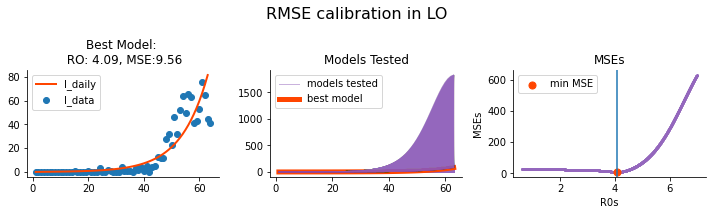

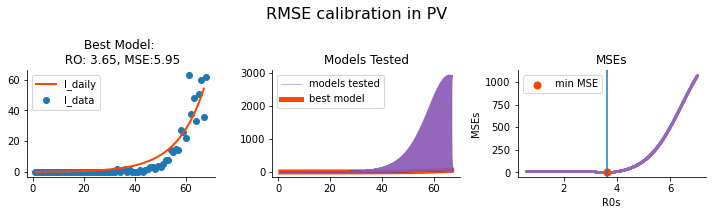

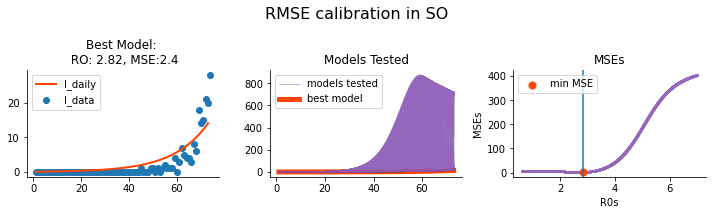

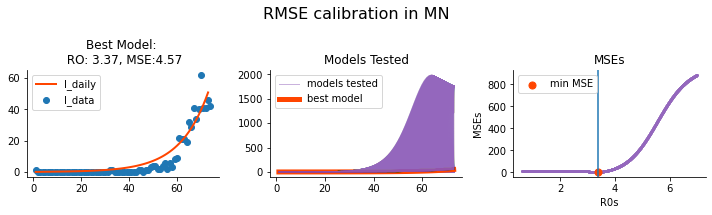

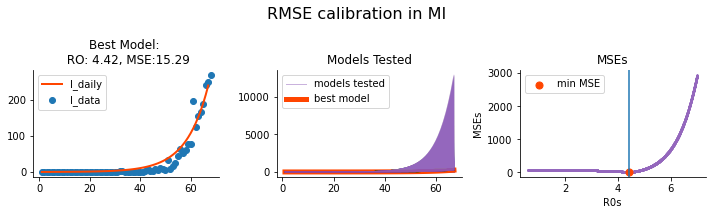

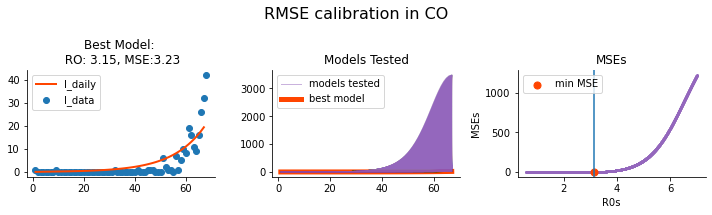

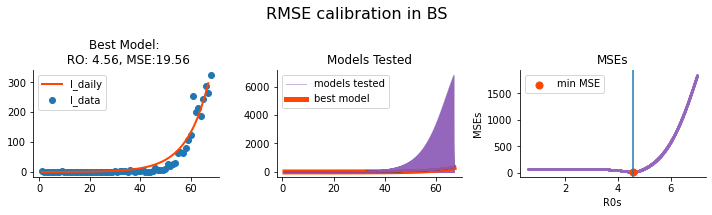

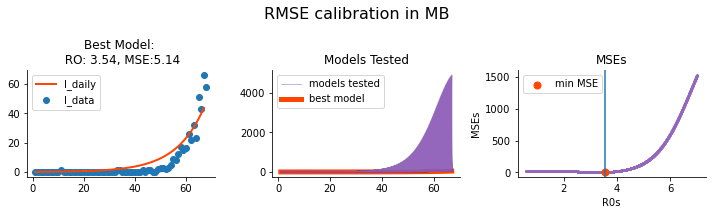

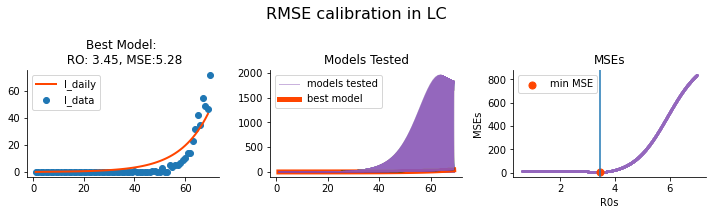

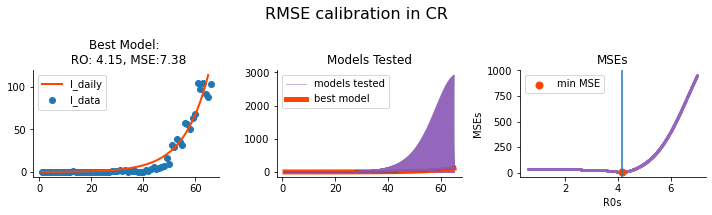

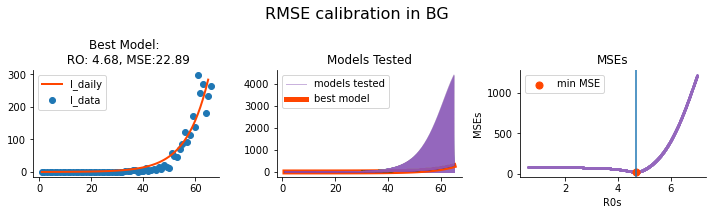

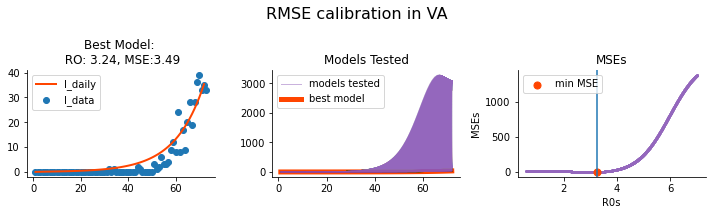

In [33]:
ind = {0:1,1:4,2:7,3:10,4:13,5:16,6:19,7:22,8:25,9:28,10:31,11:34}
pro = {i:df_provinces.columns[i] for i in range(12)}
# t_days_linspaced

for i in range(len(df_provinces.columns)):
    fig, axs = plt.subplots(1,3, facecolor='w', figsize=(10,3))
    
    fig.suptitle('RMSE calibration in '+str(pro[i]), fontsize=16)

    best_model = results.iloc[results.iloc[:,ind[i]].idxmin(),:]

    axs[0].set_title('Best Model: \n RO: {}, MSE:{}'.format(round(best_model[ind[i]-1], 2), round(best_model[ind[i]],2)))
    axs[0].scatter(t_days_linspaced[pro[i]], df_provinces[pro[i]][:len(t_days_linspaced[pro[i]])], color = 'tab:blue', label = 'I_data')
    axs[0].plot(t_days_linspaced[pro[i]][:-1],best_model[ind[i]+1], alpha=1, lw=2, label='I_daily', color = 'orangered')

    axs[1].set_title('Models Tested')
    axs[1].plot(t_days_linspaced[pro[i]][:-1], results[ind[i]+1][0], alpha=0.5,  color = 'tab:purple', lw=1, label ='models tested')
    for R0, I in zip(results.iloc[:,ind[i]-1], results.iloc[1:,ind[i]+1]):
        if R0 == best_model[ind[i]-1]:
            axs[1].plot(t_days_linspaced[pro[i]][:-1], I, c = 'orangered', lw=5, label = 'best model')
        else:
            axs[1].plot(t_days_linspaced[pro[i]][:-1], I, alpha=0.05,  color = 'tab:purple', lw=1)
        
    axs[2].set_title('MSEs')
    axs[2].scatter(results.iloc[:,ind[i]-1], results.iloc[:,ind[i]], color = 'tab:purple' , s =1 )
    axs[2].scatter(best_model[ind[i]-1], best_model[ind[i]], color = 'orangered' , s =50, label='min MSE' )
    axs[2].axvline(x= best_model[ind[i]-1], ymin=0, ymax=2, c= 'tab:blue')
    axs[2].set_xlabel('R0s')
    axs[2].set_ylabel('MSEs')

    for j in range(3):
        axs[j].legend(fancybox = True)
        for spine in ('top', 'right'): 
            axs[j].spines[spine].set_visible(False)
            
    fig.tight_layout()
    plt.savefig('graphs'+str(i)+'.png')

## (1.2) Calibration with max MLE

In [34]:
def compute_likelihood(data, data_hat):
    lkh = 1
    for i in range(len(data)-1):
        lkh = lkh * poisson.pmf(data[i],data_hat[i]) #poisson likelihood to observe the data with a model
        if str(lkh) == 'nan':
            lkh = 0
            break
    return lkh

In [35]:
def compute_loglikelihood(data, data_hat):
    llkh = 0
    for i in range(len(data)-1):
        llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i])) #poisson likelihood to observe the data with a model
    return llkh

In [36]:
like = pd.DataFrame(np.zeros((len(R0s),48)),columns = [i for i in range(48)])
counter = 0

for province in t_days_linspaced: # Run the model for each province
    llkhs = []
    lkhs = []
    I_hats = []

    N = initial_pops[province]
    inpers = 1
    y0 = N-inpers, 0, inpers, 0

    for R0 in R0s: # Run the model for each value of R0, given the province
        beta = R0*1/d 
        gamma = 1/d
        delta = 1/l
        
        # Run the model over time 
        RES = odeint(SEIR_eq, y0, t_days_linspaced[province], args=(beta, delta, gamma))

        S, E, I_hat, R = RES.T

        I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
        
        I_hats.append(I_daily)

        llkhs.append(compute_loglikelihood(df_provinces[:len(t_days_linspaced[province])][province],I_daily))
        lkhs.append(compute_likelihood(df_provinces[:len(t_days_linspaced[province])][province],I_daily))

    like[counter] = R0s
    counter += 1
    like[counter] = llkhs
    counter += 1
    like[counter] = lkhs
    counter += 1
    like[counter] = I_hats
    counter += 1

<ipython-input-35-70a1221cde7d>:4: RuntimeWarning: divide by zero encountered in log
  llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i])) #poisson likelihood to observe the data with a model


In [37]:
like.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.600,-6268.542519,0.0,"[0.003302722555354576, 0.008942460187470358, 0...",0.600,-3623.039505,0.0,"[0.003302750525053133, 0.008942537495920222, 0...",0.600,-901.942150,...,0.0,"[0.003302750857973269, 0.008942538416112367, 0...",0.600,-inf,0.0,"[0.0033027694003457952, 0.008942589667378709, ...",0.600,-2437.586907,0.0,"[0.0033027556316262974, 0.008942551610528149, ..."
1,0.601,-6264.804050,0.0,"[0.0033082303100977484, 0.00895740820331925, 0...",0.601,-3620.649049,0.0,"[0.003308258327114011, 0.008957485645476826, 0...",0.601,-901.213506,...,0.0,"[0.003308258660598362, 0.008957486567259032, 0...",0.601,-inf,0.0,"[0.003308277234340018, 0.00895753790716669, 0....",0.601,-2435.819698,0.0,"[0.0033082634423267088, 0.008957499784499445, ..."
2,0.602,-6261.069078,0.0,"[0.003313738075599648, 0.00897235636546756, 0....",0.602,-3618.260778,0.0,"[0.0033137661399413876, 0.008972433941343505, ...",0.602,-900.485519,...,0.0,"[0.0033137664739861794, 0.008972434864719547, ...",0.602,-inf,0.0,"[0.0033137850791002954, 0.008972486293273185, ...",0.602,-2434.054078,0.0,"[0.003313771263792731, 0.008972448104776376, 0..."
3,0.603,-6257.337596,0.0,"[0.003319245851864938, 0.00898730467390818, 0....",0.603,-3615.874687,0.0,"[0.0033192739635306, 0.00898738238352026, 0.01...",0.603,-899.758188,...,0.0,"[0.003319274298139163, 0.008987383308488806, 0...",0.603,-inf,0.0,"[0.0033192929346266276, 0.008987434825702856, ...",0.603,-2432.290044,0.0,"[0.003319279096022587, 0.008987396571372486, 0..."
4,0.604,-6253.609592,0.0,"[0.003324753638892064, 0.009002253128638449, 0...",0.604,-3613.490771,0.0,"[0.0033247817978812044, 0.00900233097200731, 0...",0.604,-899.031511,...,0.0,"[0.003324782133054871, 0.009002331898569249, 0...",0.604,-inf,0.0,"[0.003324800800917682, 0.009002383504451927, 0...",0.604,-2430.527592,0.0,"[0.0033247869390160556, 0.009002345184278449, ..."


We have to choose the best model for each province, and for this reason we look for the model that maximizes the log-likelihood. To make a double check, we also run the same algorithm, but this time maximizing the likelihood function. We should expect both of the outputs to be the same, since likelihood and its log version are maximised at the same point.

In [38]:
for i in range(1,len(like.columns)+1,4):
    best_model = like.iloc[like.iloc[:,i].idxmax(),:]
    print('BEST MODEL: RO: {}, llkhs:{}'.format(round(best_model[i-1], 2), round(best_model[i],2)))

BEST MODEL: RO: 4.13, llkhs:-186.71
BEST MODEL: RO: 3.58, llkhs:-153.07
BEST MODEL: RO: 2.69, llkhs:-99.97
BEST MODEL: RO: 3.3, llkhs:-159.6
BEST MODEL: RO: 4.35, llkhs:-308.33
BEST MODEL: RO: 3.01, llkhs:-120.53
BEST MODEL: RO: 4.49, llkhs:-362.54
BEST MODEL: RO: 3.41, llkhs:-152.3
BEST MODEL: RO: 3.31, llkhs:-171.38
BEST MODEL: RO: 4.11, llkhs:-179.15
BEST MODEL: RO: 4.64, llkhs:-312.44
BEST MODEL: RO: 3.15, llkhs:-137.33


In [39]:
for i in range(2,len(like.columns)+1,4):
    best_model = like.iloc[like.iloc[:,i].idxmax(),:]
    print('BEST MODEL: RO: {}, lkhs:{}'.format(round(best_model[i-2], 2), round(best_model[i],2)))

BEST MODEL: RO: 4.13, lkhs:0.0
BEST MODEL: RO: 3.58, lkhs:0.0
BEST MODEL: RO: 2.69, lkhs:0.0
BEST MODEL: RO: 3.3, lkhs:0.0
BEST MODEL: RO: 4.35, lkhs:0.0
BEST MODEL: RO: 3.01, lkhs:0.0
BEST MODEL: RO: 4.49, lkhs:0.0
BEST MODEL: RO: 3.41, lkhs:0.0
BEST MODEL: RO: 3.31, lkhs:0.0
BEST MODEL: RO: 4.11, lkhs:0.0
BEST MODEL: RO: 4.64, lkhs:0.0
BEST MODEL: RO: 3.15, lkhs:0.0


We store all the best values for each province in a single matrix, since it might be useful.

In [40]:
MLE_R0s = []

for i in range(2,len(like.columns)+1,4):
    best_model = like.iloc[like.iloc[:,i].idxmax(),:]
    MLE_R0s.append(best_model[i-2])

beta_MLE = pd.DataFrame(np.array(MLE_R0s).reshape(-1,len(MLE_R0s)),columns = t_days_linspaced.keys(),index=['R0'])
beta_MLE.loc['beta',:] = beta_MLE.iloc[0,:]*gamma

beta_MLE

,LO,PV,SO,MN,MI,CO,BS,MB,LC,CR,BG,VA
R0,4.126000,3.580000,2.691000,3.296000,4.345000,3.010,4.492000,3.405000,3.313000,4.112000,4.637000,3.154000
beta,0.294714,0.255714,0.192214,0.235429,0.310357,0.215,0.320857,0.243214,0.236643,0.293714,0.331214,0.225286


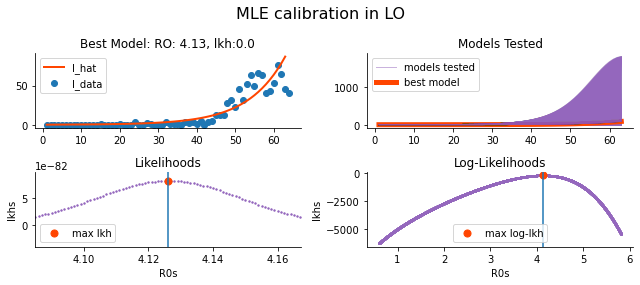

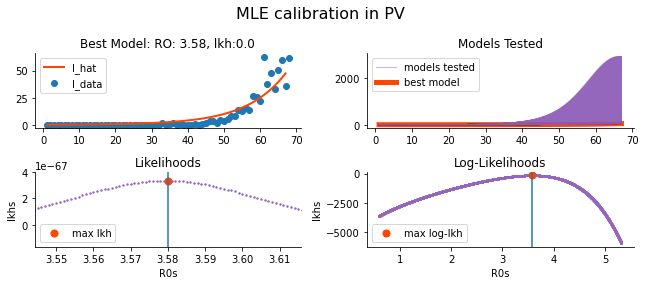

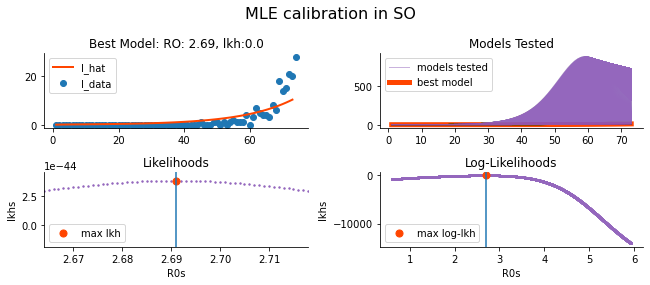

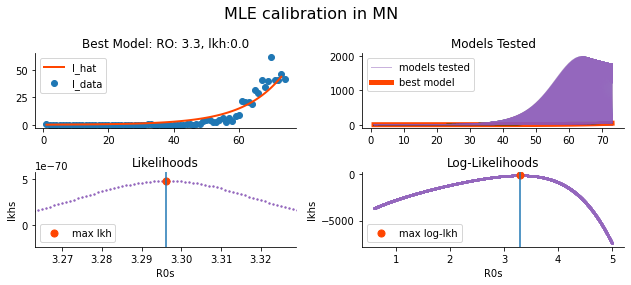

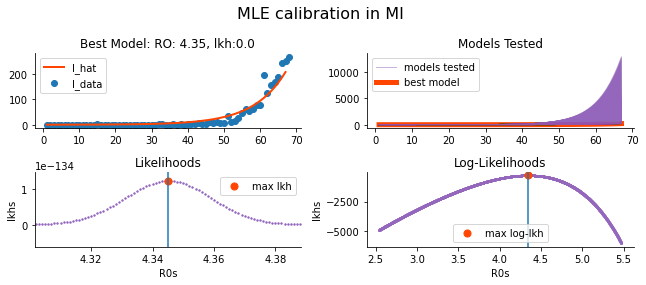

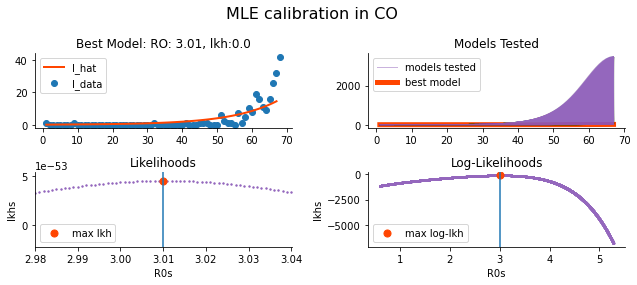

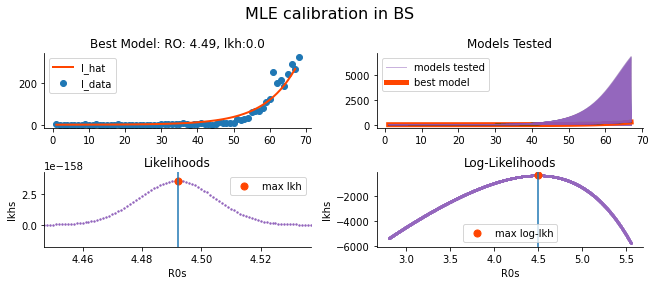

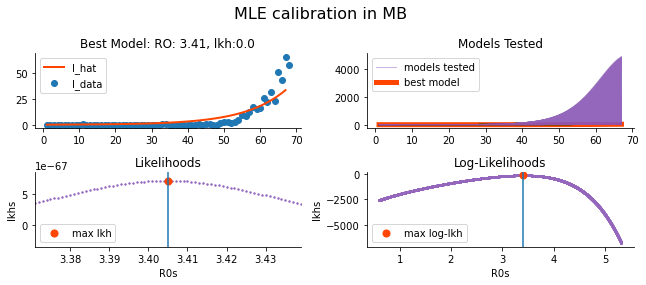

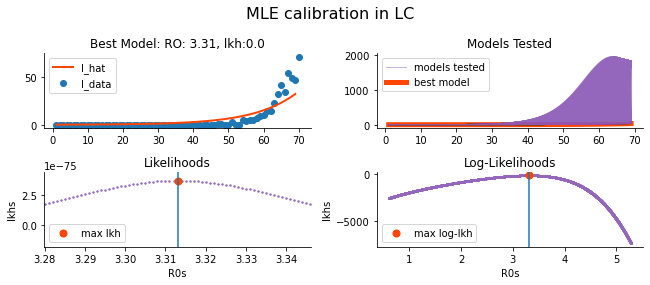

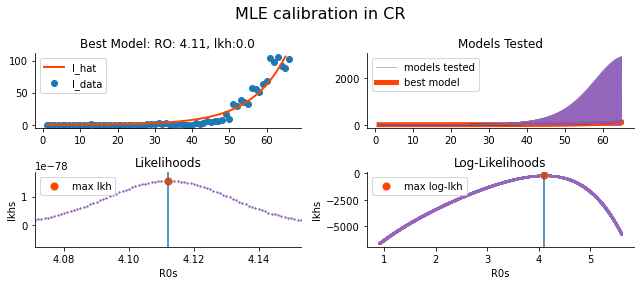

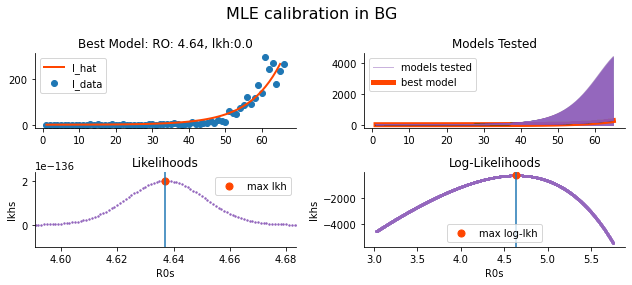

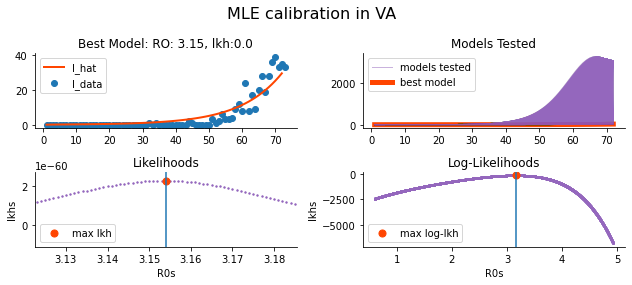

In [43]:
ind = defaultdict()
counter = -3
for i in range(12):
    counter += 4
    ind[i] = counter

pro = {i:df_provinces.columns[i] for i in range(12)}


for i in range(len(df_provinces.columns)):

    fig, axs = plt.subplots(2,2, facecolor='w', figsize=(9,4))
    
    fig.suptitle('MLE calibration in '+str(pro[i]), fontsize=16)

    best_model = like.iloc[like.iloc[:,ind[i]+1].idxmax(),:]

    axs[0,0].set_title('Best Model: RO: {}, lkh:{}'.format(round(best_model[ind[i]-1], 2), round(best_model[ind[i]+1],2)))
    #axs[0,0].scatter(t, data.cum_cases, color = 'b', label = 'I_data')
    axs[0,0].scatter(t_days_linspaced[pro[i]], df_provinces[pro[i]][:len(t_days_linspaced[pro[i]])], color = 'tab:blue', label = 'I_data')

    axs[0,0].plot(t_days_linspaced[pro[i]][:-1],best_model[ind[i]+2], alpha=1, lw=2, label='I_hat', color = 'orangered')


    axs[0,1].set_title('Models Tested')

    axs[0,1].plot(t_days_linspaced[pro[i]][:-1], like[ind[i]+2][0], alpha=0.5,  color = 'tab:purple', lw=1, label ='models tested' )
    for R0, I in zip(like.iloc[:,ind[i]-1], like.iloc[1:,ind[i]+2]):
        if R0 == best_model[ind[i]-1]:
            axs[0,1].plot(t_days_linspaced[pro[i]][:-1], I, c = 'orangered', lw=5, label = 'best model')
        else:
            axs[0,1].plot(t_days_linspaced[pro[i]][:-1], I, alpha=0.05,  color = 'tab:purple', lw=1)

    axs[1,0].set_title('Likelihoods')
    axs[1,0].scatter(like.iloc[:,ind[i]-1], like.iloc[:,ind[i]+1], color = 'tab:purple' , s =2 )
    axs[1,0].scatter(best_model[ind[i]-1], best_model[ind[i]+1], color = 'orangered' , s =50, label='max lkh' )
    axs[1,0].axvline(x = best_model[ind[i]-1], ymin=0, ymax=2, c= 'tab:blue')
    axs[1,0].set_ylim(-best_model[ind[i]+1]/2 , best_model[ind[i]+1]*1.2)
    axs[1,0].set_xlim(best_model[ind[i]-1]*(1-0.01) , best_model[ind[i]-1]*1.01)

    axs[1,0].set_xlabel('R0s')
    axs[1,0].set_ylabel('lkhs')


    axs[1,1].set_title('Log-Likelihoods')
    axs[1,1].scatter(like.iloc[:,ind[i]-1], like.iloc[:,ind[i]], color = 'tab:purple' , s =2 )
    axs[1,1].scatter(best_model[ind[i]-1], best_model[ind[i]], color = 'orangered' , s =50, label='max log-lkh' )
    axs[1,1].axvline(x = best_model[ind[i]-1], ymin=0, ymax=2, c= 'tab:blue')

    axs[1,1].set_xlabel('R0s')
    axs[1,1].set_ylabel('lkhs')

    for i in range(2):
        for j in range(2):
            axs[i,j].legend(fancybox = True)
            for spine in ('top', 'right'): 
                axs[i,j].spines[spine].set_visible(False)
            
    fig.tight_layout()
    plt.savefig('like'+str(i)+'.png')

## (1.3) Metropolis Hastings

We first define our metropolis_hastings algorithm.

In [53]:
def metropolis_hastings(iterations, time, y0, beta_start, delta, gamma, std, true_data):
    
    RES = odeint(SEIR_eq, y0, time, args=(beta_start, delta, gamma))
    I_hat, R = RES.T[2:]
    I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
    llkh_start = compute_loglikelihood(true_data, I_daily)
    
    
    BETAS =[beta_start]
    llkh = [llkh_start]
    
    for ITER in range(iterations):
    
        beta_current = BETAS[-1]
        llkh_current = llkh[-1]

        beta_new = np.random.normal(beta_current, std, size = 1)

        RES = odeint(SEIR_eq, y0, time, args=(beta_new, delta, gamma))
        I_hat, R = RES.T[2:]
        I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
        llkh_new = compute_loglikelihood(true_data, I_daily)

        alpha  = np.e**(llkh_new - llkh_current)

        if alpha <= np.random.uniform(0,1): 
            BETAS.append(beta_current)
            llkh.append(llkh_current)

        else: 
            BETAS.append(beta_new)
            llkh.append(llkh_new)
      
    # We discard the first 400 iterations. 

    BETAS = BETAS[400:] 
    llkh = llkh[400:]
    
    return np.array(BETAS).flatten(), np.array(llkh).flatten()



We run the MCMC simulation for each province three times, starting from different values of beta and each time performing a number of 4000 iterations. We then store our three estimated betas in a matrix, with the provinces as columns.

In [54]:
metrhast = defaultdict()

std = 0.01
iterations = 4000

for province in t_days_linspaced:
    N = initial_pops[province]
    inpers = 1
    y0 = N-inpers, 0, inpers, 0

    BETAS_1, llkh_1 = metropolis_hastings(iterations, t_days_linspaced[province], y0, 0.3, delta, gamma, std,df_provinces[province][:len(t_days_linspaced[province])])  
    BETAS_2, llkh_2 = metropolis_hastings(iterations, t_days_linspaced[province], y0, 0.2, delta, gamma, std,df_provinces[province][:len(t_days_linspaced[province])]) 
    BETAS_3, llkh_3= metropolis_hastings(iterations, t_days_linspaced[province], y0, 0.4, delta, gamma, std,df_provinces[province][:len(t_days_linspaced[province])])

    B = [BETAS_1, BETAS_2, BETAS_3]
    LLK = [llkh_1, llkh_2, llkh_3]
    
    metrhast[province] = B , LLK

<ipython-input-35-70a1221cde7d>:4: RuntimeWarning: divide by zero encountered in log
  llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i])) #poisson likelihood to observe the data with a model
<ipython-input-53-0597a0228d5a>:24: RuntimeWarning: invalid value encountered in double_scalars
  alpha  = np.e**(llkh_new - llkh_current)
<ipython-input-53-0597a0228d5a>:24: RuntimeWarning: overflow encountered in double_scalars
  alpha  = np.e**(llkh_new - llkh_current)


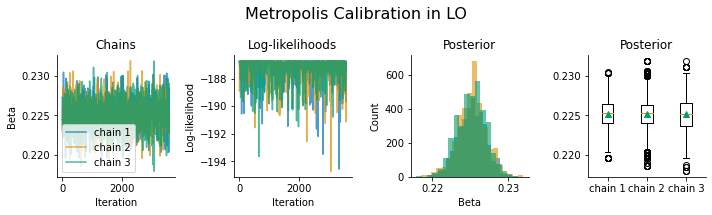

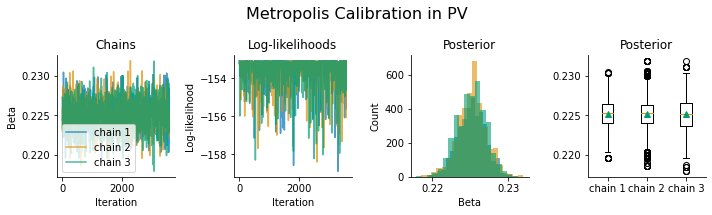

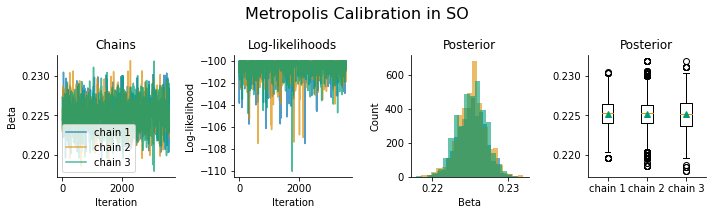

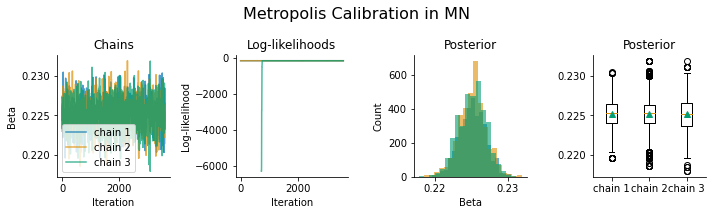

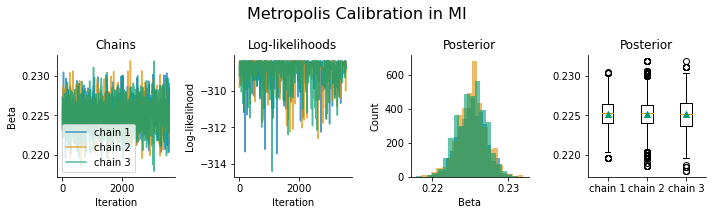

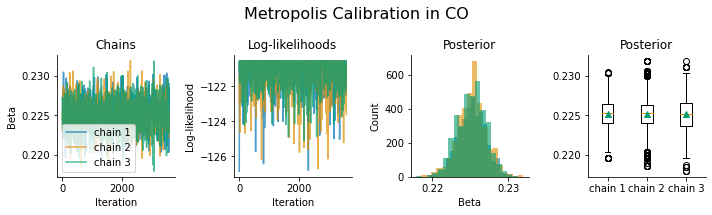

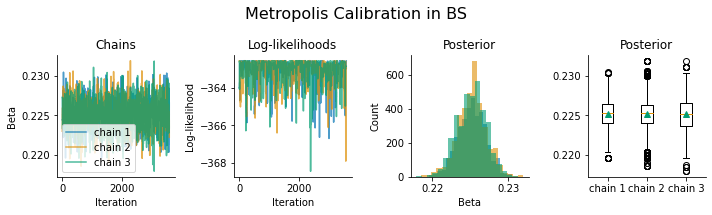

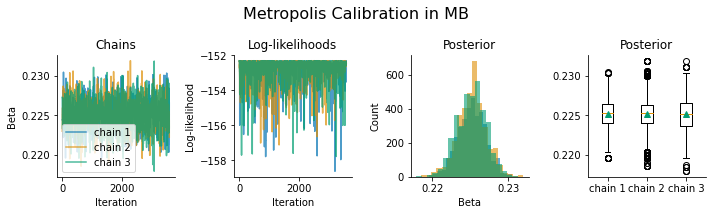

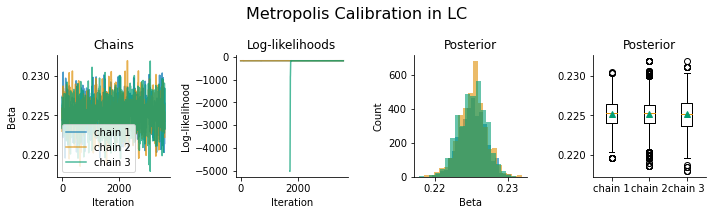

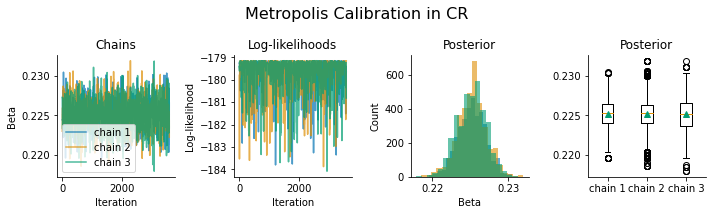

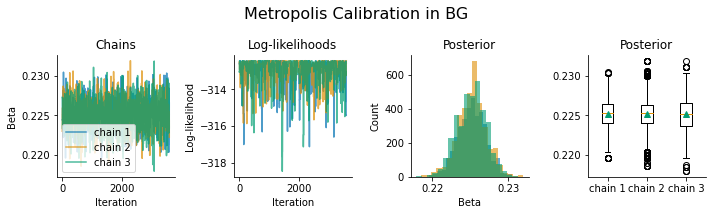

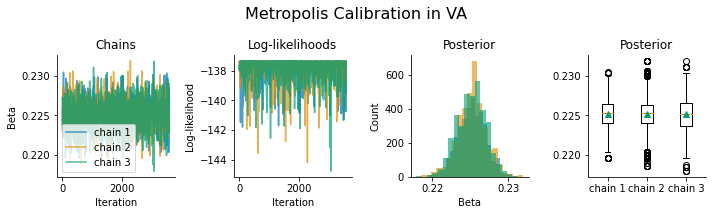

In [55]:
for province in metrhast:

    BETAS = metrhast[province][0]
    LLK = metrhast[province][1]

    fig, axs = plt.subplots(1,4, facecolor='w', figsize=(10,3))

    fig.suptitle('Metropolis Calibration in '+str(province), fontsize=16)
    axs[0].set_title('Chains')
    axs[1].set_title('Log-likelihoods')
    axs[2].set_title('Posterior')
    axs[3].set_title('Posterior')

    for i in range(3):
        BETAS = B[i]
        llk = LLK[i]
        
        axs[0].plot(range(len(BETAS)), BETAS, label = 'chain {}'.format(i+1), alpha = 0.7)
        axs[1].plot(range(len(llk)), llk, alpha = 0.7)
        axs[2].hist(BETAS, bins = 20, alpha = 0.6)

    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Beta')

    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Log-likelihood')

    axs[2].set_xlabel('Beta')
    axs[2].set_ylabel('Count')

    axs[3].boxplot(B, showmeans=True)
    plt.setp(axs[3], xticklabels=['chain 1', 'chain 2', 'chain 3']);

    axs[0].legend(fancybox = True)

    for i in range(4):
        for spine in ('top', 'right'): 
            axs[i].spines[spine].set_visible(False)
            
    fig.tight_layout()
    plt.savefig('metrhast'+str(province)+'.png')

In [56]:
metrhast_beta = pd.DataFrame(np.zeros((3,12)),columns = df_provinces.columns)

for province in metrhast:
    BETAS = metrhast[province][0]
    BETAS_1 = BETAS[0]
    BETAS_2 = BETAS[1]
    BETAS_3 = BETAS[2]
    metrhast_beta[province] = [np.mean(BETAS_1), np.mean(BETAS_2), np.mean(BETAS_3)]
    
metrhast_beta

,LO,PV,SO,MN,MI,CO,BS,MB,LC,CR,BG,VA
0,0.294702,0.255636,0.192041,0.235505,0.310361,0.214822,0.320964,0.243292,0.236531,0.293780,0.331266,0.225219
1,0.294743,0.255656,0.192189,0.235461,0.310404,0.214935,0.320825,0.243034,0.236469,0.293710,0.331233,0.225225
2,0.294789,0.255578,0.192212,0.310089,0.310336,0.215033,0.320920,0.243286,0.432991,0.293778,0.331198,0.225145


## (1.4) Simulation

To answer the final question of the first exercise, we take the betas calibrated in the MCMC procedure and, this way, we have all the parameters to run SEIR models for each province for the whole time-span of 92 days. 

Even before running the 12 SEIR algorithms, we can safely affirm that the simulated data and the true data will not overlap in the last part of the plot. In fact, while Italy decided to implement social distancing measures and imposed a lockdown soon after the first contagion wave begun, our simple SEIR model does not comprise any restrictive measure and will likely increase in an exponential way even in the second part of the plot. 

In [50]:
t = np.arange(1, df_provinces.shape[0], 1) # Set the number of days as the whole time-span comprised by the Italian dataset

betas = {element[0]: element[1] for element in list(zip(metrhast_beta.columns,metrhast_beta.iloc[1,:].values))} # Use the 
                                                                                                                # MCMC betas

total_simulated = defaultdict()

gamma = 1/14 # Assume gamma to be 1/14 as 14 is the number of days one person remains infectious, on average

for province in initial_pops: # Run the SEIR 12 times, one for each province
    
    N = initial_pops[province] # Set the initial population N as the true population of each province
    inf = 1 # Start with one infected person, as it was the beginning of the pandemic
    y0 = N-inf, 0, inf, 0 # Initialize the parameters
    
    beta = betas[province] # Pick the beta that corresponds to the right province, from the ones stored in our MCMC calibration
    
    RES = odeint(SEIR_eq, y0, t, args=(beta, delta, gamma)) # Run the model over the whole span of 92 days
    
    S, E, I_hat, R = RES.T
    
    I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1]) # Store the new cases, as our Italian data correspond to new cases 
    
    total_simulated[province] = I_daily   
    


The following 12 graphs represent the plot of the true data vs the simulated data for each province.

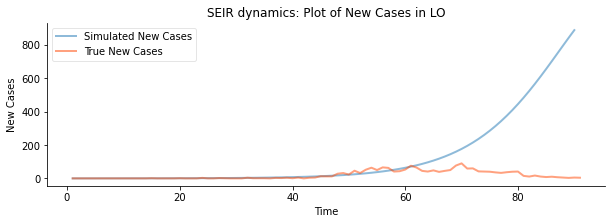

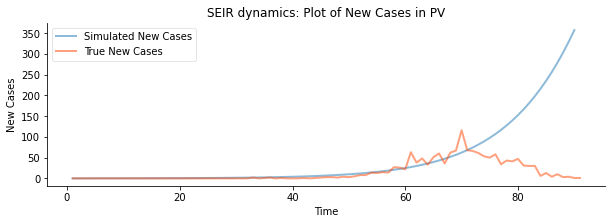

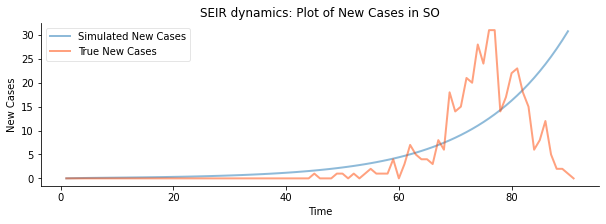

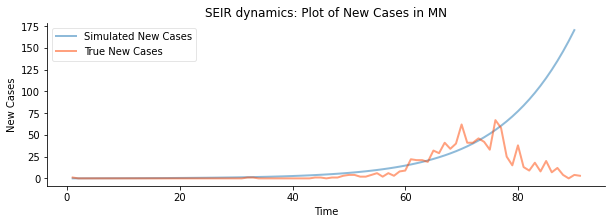

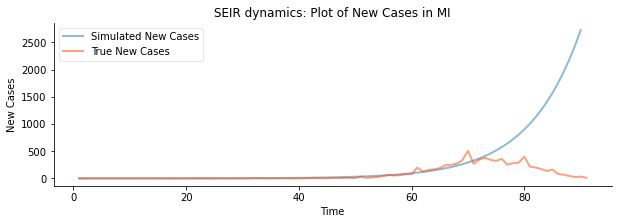

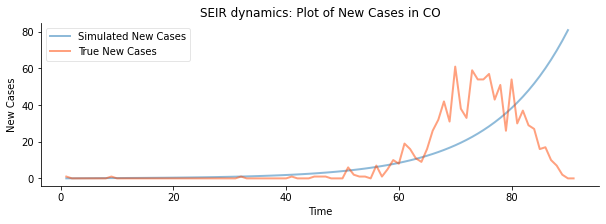

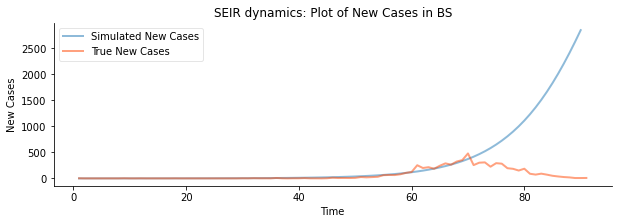

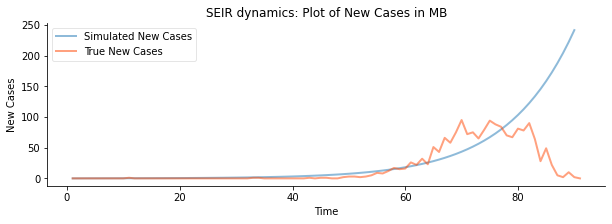

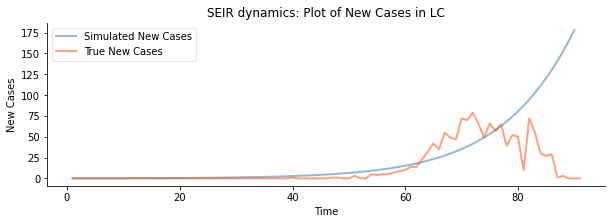

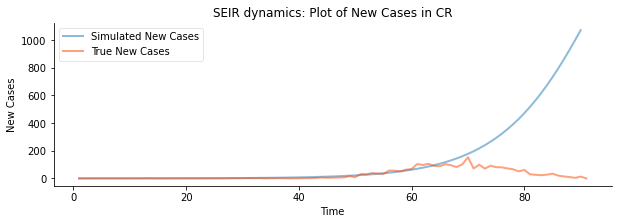

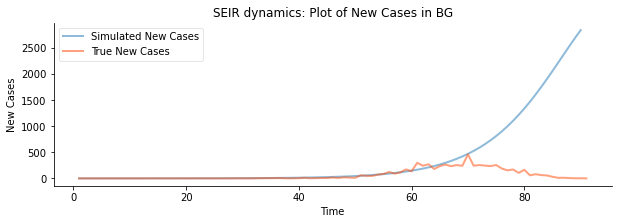

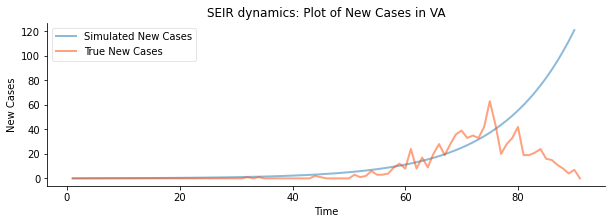

In [51]:

for province in initial_pops:

    fig, axs = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(10,3))

    ax = axs
    ax.set_title('SEIR dynamics: Plot of New Cases in '+str(province))

    ax.plot(t[:-1], total_simulated[province], 'tab:blue', alpha=0.5, lw=2, label= 'Simulated New Cases')
    ax.plot(t, df_provinces[province][:-1], 'orangered', alpha=0.5, lw=2, label= 'True New Cases')

    ax.set_xlabel('Time')
    ax.set_ylabel('New Cases')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)